# Denmark's demographic development towards 2070

**This data project examines Denmark's demographic evolution until 2070, leveraging data from Danmarks Statistik. The project analyzes the population composition, including age, gender, and origin. Further, the project examines population projections and generates interactive population pyramids for Denmark spanning from 2023 to 2070.**

Imports and set magics:

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings('ignore')


plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from IPython.display import display # For interactive figure

# Installing DSTAPI to get data from statistikbanken
%pip install git+https://github.com/alemartinello/dstapi
from dstapi import DstApi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Importing the data model, labelling it 'data'
import dataproject
data = dataproject

  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/p7/7tzkd8sx4b93zx28gwq44bc80000gn/T/pip-req-build-f28tk1lm
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/p7/7tzkd8sx4b93zx28gwq44bc80000gn/T/pip-req-build-f28tk1lm
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Data import and cleaning

**1.1) We firstly import and read data from the Danmarks Statistik API:**

In [7]:
# importing and reading data from DST API
pop = DstApi('FRDK123') #Defining the data set
params = pop._define_base_params(language='en') #Language is set to english
pop.tablesummary(language='en') #Getting the table summary

Table FRDK123: Befolkningsfremskrivning 2023 for hele landet efter herkomst, køn, alder og tid
Last update: 2023-06-01T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,HERKOMST,5,999,Personer med dansk oprindelse,35,Efterkommere fra ikke-vestlige lande,False
1,KØN,2,M,Mænd,K,Kvinder,False
2,ALDER,106,0,0 år,105-,105 år og derover,False
3,Tid,48,2023,2023,2070,2070,True


The above table summary shows the key information for the variables of our imported data set. There are five different values for "HERKOMST": people of Danish origin, immigrants from western and non-western countries, and descendants from western and non-western countries. The data is split into genders, male and female, and ages span from 0 to 105. Lastly, we look at projections from 2023 to 2070. 

**1.2) Secondly, we clean data by defining the variables for use in our project:**

In [8]:
#Defining the variables we want to use
params = {'table': 'FRDK123',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'HERKOMST', 'values': ['*']},
  {'code': 'KØN', 'values': ['M', 'K']},
  {'code': 'ALDER', 'values': ['>=0<=100']},
  {'code': 'Tid', 'values': ['*']}]}

#Getting the data
datapop_api = pop.get_data(params=params)

datapop_api['ALDER'] = datapop_api['ALDER'].str.extract('(\d+)').astype(int)

datapop_api.sample(n=10)


,HERKOMST,KØN,ALDER,TID,INDHOLD
25663,Descendants from non-western countries,Women,42,2052,2111
22268,Descendants from western countries,Women,96,2050,6
37212,Immigrants from western countries,Men,26,2028,3794
37838,Descendants from non-western countries,Men,49,2028,446
28059,Immigrants from western countries,Women,56,2051,3016
32949,Descendants from western countries,Women,69,2070,238
5230,Immigrants from non-western countries,Women,14,2056,558
32062,Immigrants from western countries,Men,16,2045,721
32208,Immigrants from non-western countries,Women,57,2045,4350
36835,Descendants from non-western countries,Men,50,2044,2050


The above table summary shows a random sample of 10 values from our dataset, where "INDHOLD" is the population in the category. 

## 2) Population pyramids

**2.1) Firsly, we present the data for 2023 in a population pyramid:**

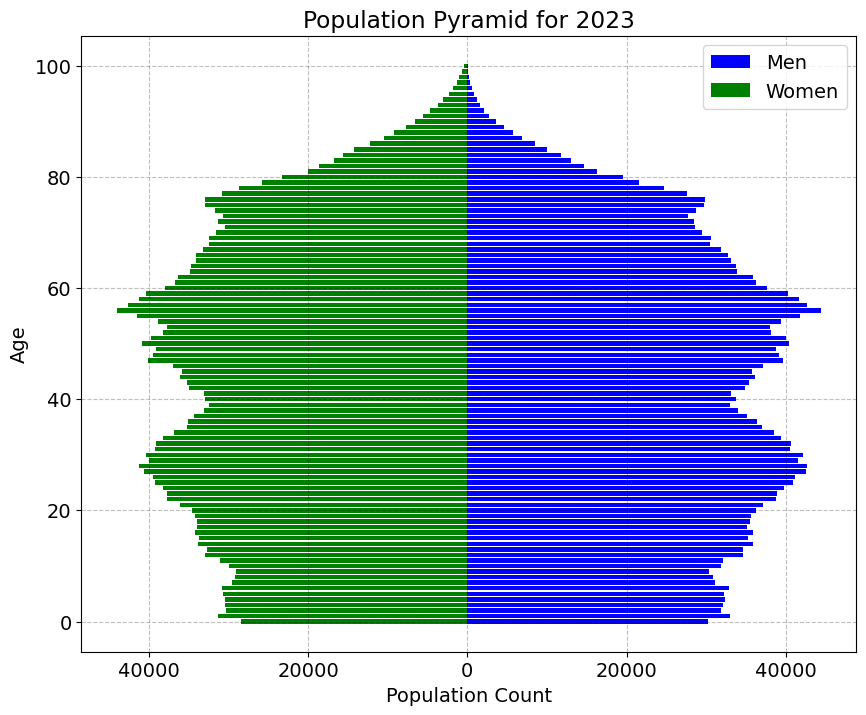

In [9]:
# Refering to 'data' - plotting the population pyramid
df = datapop_api[datapop_api["TID"] == 2023]
datapop_df = df.groupby(["KØN", "ALDER"])["INDHOLD"].sum().reset_index()
data.plot_population_pyramid(datapop_df)

The above figure shows the actual population data for 2023 in a population pyramid. 

In 2023, Denmark's population pyramid exhibits a notable middle-aged demographic bulge alongside an increasing elderly population, illustrating ongoing demographic shifts driven by lower birth rates and increased life expectancy typical of developed nations. This age structure highlights Denmark's evolving population dynamics, with implications for social services, healthcare, and economic policies aimed at supporting an aging population.


**2.2) Secondly, we show the population projections in an interactive plot:**

In [12]:
# Function to call the plot in ipynp-file

def update_plot(year):
    # Filtering the DataFrame for the selected year
    df_year = datapop_api[datapop_api["TID"] == year]
    
    # Grouping by gender and age, then sum the population count
    age_pyramid_data = df_year.groupby(["KØN", "ALDER"])["INDHOLD"].sum().unstack("KØN")
    
    # Making women's population negative for plotting
    age_pyramid_data['Women'] = -age_pyramid_data['Women']

    # Clearing the previous figure and create a new one
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plotting the data
    ax.barh(age_pyramid_data.index, age_pyramid_data['Men'], color='blue', label='Men')
    ax.barh(age_pyramid_data.index, age_pyramid_data['Women'], color='green', label='Women')

    # Setting labels and title
    ax.set_xlabel('Population Count')
    ax.set_ylabel('Age')
    ax.set_title(f'Population Pyramid for {year}')
    ax.legend()


    ax.set_ylim(0, age_pyramid_data.index.max())

    # Changing y-axis to show only labels for every 5 years
    # Finding the max age to set as the limit for the y-axis ticks
    # max_age = age_pyramid_data.index.max() + (5 - age_pyramid_data.index.max() % 5)  # Round up to the nearest multiple of 5
    ax.set_yticks(np.arange(0, 101, 5))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure that only integer ticks are shown

    # Setting the x-axis to show positive values for both sides
    ticks = ax.get_xticks()
    ax.set_xticklabels([int(abs(tick)) for tick in ticks])

    # Showing grid
    ax.grid(True)

    # Displaying the plot
    plt.show()

# Creating a slider for the year selection
years = datapop_api['TID'].unique()
year_slider = widgets.IntSlider(min=min(years), max=max(years), step=1, value=min(years), description='Year')

# Displaying the slider and attaching the update function
widgets.interactive(update_plot, year=year_slider)

interactive(children=(IntSlider(value=2023, description='Year', max=2070, min=2023), Output()), _dom_classes=(…


The interactive plot above displays population projections from 2023 to 2070 using population pyramids. By adjusting the slider, you can change the year, and the figure updates accordingly.

Qualitatively, the plot reveals several key insights. Firstly, there's a noticeable rise in the older population over the years, signaling a demographic transition towards an aging society. The population pyramid for 2023 highlights two distinct spikes corresponding to previous high birth rates: one represented by a sizable cohort now aged around 60 years, and another group aged around 30 years. As these cohorts age, we anticipate a larger elderly population in the future.

A remarkable observation is the evolving shape of the pyramid. Specifically, the apex of the pyramid gradually flattens in the future, with more mass concentrated towards the top, indicating an upward trend in average life expectancy.

Additionally, the projected distribution of the population shows a somewhat larger proportion in the future, suggesting overall population growth.

Another noteworthy trend is the fluctuation in the projected birth rate. Around the year 2030, there is a significant spike in newborns, followed by a gradual decline in subsequent years. As the slider is moved towards later years, this spike in newborns ages, indicating a shift towards an older population structure over time.

# 3) Demograhic compositions

In this sections, we cover demographic compositions over time, wrt. age and origin.

**3.1) Population projection by age group, 2023-2070:**

<Figure size 1000x600 with 0 Axes>

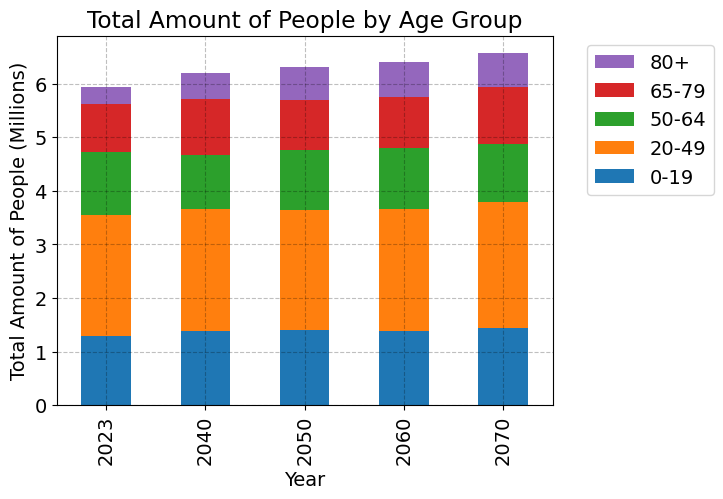

In [ ]:
# Creating bar plot with age for specific years
selected_years = [2023, 2040, 2050, 2060, 2070]
data.plot_age_groups(datapop_api, selected_years)

The plot above illustrates population projections by age groups. Notably, it reveals a considerable rise in the Danish population until 2070, with a particularly noticeable increase in the older age brackets of 65-79 and 80+. This significant surge in the elderly population, alongside the relatively steady distribution among younger age groups, highlights a notable demographic shift. Such a pronounced trend towards an aging population could pose challenges for governmental policies and resource distribution in the future.

**3.2) Population projection by origin, 2023-2070:**

<Figure size 1000x600 with 0 Axes>

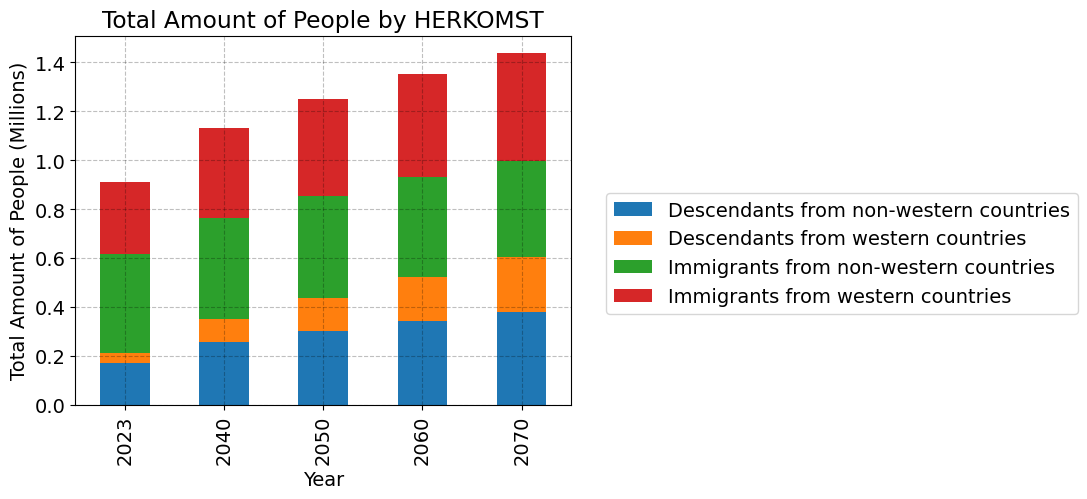

In [ ]:
# Creating bar plot with herkomst for specific years
selected_years = [2023, 2040, 2050, 2060, 2070]
data.plot_herkomst_groups(datapop_api, selected_years)

The above figure illustrates a substantial increase in immigrants and their descendants from 2023 to 2070. Specifically, there's a significant rise in descendants from both western and non-western countries, aligning with the anticipated high rates of immigration during these years.

# Conclusion


This data project examines Denmark's population projections from 2023 to 2070, revealing anticipated demographic shifts. The population is expected to grow, driven primarily by an increase in immigrants and their descendants. Notably, there's a significant surge projected in older individuals, signaling a shift towards an aging population. Additionally, life expectancy is forecasted to rise. These insights highlight the challenges and opportunities facing policymakers in adapting to evolving demographic trends.